<a href="https://www.kaggle.com/code/giuliapais/leveraging-random-forest-for-leukemia-typing?scriptVersionId=158211186" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gene-expression/data_set_ALL_AML_independent.csv
/kaggle/input/gene-expression/data_set_ALL_AML_train.csv
/kaggle/input/gene-expression/actual.csv


# Data import

In [2]:
training_data = pd.read_csv('/kaggle/input/gene-expression/data_set_ALL_AML_train.csv')
labels = pd.read_csv('/kaggle/input/gene-expression/actual.csv')
test_data = pd.read_csv('/kaggle/input/gene-expression/data_set_ALL_AML_independent.csv')

In [3]:
training_data.shape

(7129, 78)

In [4]:
training_data.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [5]:
test_data.shape

(7129, 70)

In [6]:
test_data.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [7]:
labels

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL
...,...,...
67,68,ALL
68,69,ALL
69,70,ALL
70,71,ALL


# Data exploration

In [8]:
import re
# Fixing the column names for calls (training data) - columns are not in order
training_df = training_data.copy()
prev_col = None
col_renaming_map = {}
for col in training_df.columns:
    if (col == 'Gene Description' or col == 'Gene Accession Number'):
        continue
    if (re.match('^\d+$', col)):
        prev_col = col
        continue
    col_renaming_map[col] = f'call.{prev_col}'
training_df.rename(columns=col_renaming_map, inplace=True)

In [9]:
# Fixing the column names for calls (test data) - columns are not in order
test_df = test_data.copy()
prev_col = None
col_renaming_map = {}
for col in test_df.columns:
    if (col == 'Gene Description' or col == 'Gene Accession Number'):
        continue
    if (re.match('^\d+$', col)):
        prev_col = col
        continue
    col_renaming_map[col] = f'call.{prev_col}'
test_df.rename(columns=col_renaming_map, inplace=True)

In [10]:
# Saving the patients for later use
patients_in_train = pd.to_numeric(training_data[[col for col in training_data.columns if re.match('^\d+$', col)]].columns).sort_values()
patients_in_test = pd.to_numeric(test_data[[col for col in test_data.columns if re.match('^\d+$', col)]].columns).sort_values()

In [11]:
# Merging all data
all_data = pd.merge(training_df, test_df, on=['Gene Description', 'Gene Accession Number'], how='outer')

In [12]:
# Reshaping data for data visualization
call_columns = [col for col in all_data.columns if col.startswith('call.')]
melted_calls = all_data.melt(id_vars=['Gene Description', 'Gene Accession Number'], value_vars=call_columns, 
                       var_name='call', value_name='call_val')
melted_calls['call'] = melted_calls['call'].replace('call.', '', regex=True)
melted_calls['call'] = pd.to_numeric(melted_calls['call'])

pt_columns = [col for col in all_data.columns if col.isdigit()]
melted_pt = all_data.melt(id_vars=['Gene Description', 'Gene Accession Number'], value_vars=pt_columns, 
                       var_name='pt', value_name='expr')
melted_pt['pt'] = pd.to_numeric(melted_pt['pt'])

gene_pt_calls = pd.merge(melted_pt, melted_calls, left_on=['Gene Description', 'Gene Accession Number', 'pt'], 
                         right_on=['Gene Description', 'Gene Accession Number', 'call'], how='left')
# Adding labels
gene_pt_calls = pd.merge(gene_pt_calls, labels, left_on='pt', right_on='patient', how='left')
gene_pt_calls

,Gene Description,Gene Accession Number,pt,expr,call,call_val,patient,cancer
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,1,-214,1,A,1,ALL
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,1,-153,1,A,1,ALL
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,1,-58,1,A,1,ALL
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,1,88,1,A,1,ALL
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,1,-295,1,A,1,ALL
...,...,...,...,...,...,...,...,...
513283,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,X83863_at,62,551,62,A,62,AML
513284,HMG2 High-mobility group (nonhistone chromosom...,Z17240_at,62,194,62,A,62,AML
513285,RB1 Retinoblastoma 1 (including osteosarcoma),L49218_f_at,62,20,62,A,62,AML
513286,GB DEF = Glycophorin Sta (type A) exons 3 and ...,M71243_f_at,62,379,62,A,62,AML


The "call" columns provide a qualitative assessment of the presence or absence of gene expression based on the signal intensity for each gene in each sample: usually, the categories are "Present" (P), "Absent" (A), and "Marginal" (M). It is important to note that these are not simply a qualitative indication of the level of expression but are the result of a non-parametric statistical test (usually performed by the MAS5 algorithm) [McClintick JN, Edenberg HJ, 2006](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1409797/).

Before proceeding, let us also take a look at the expression of the endogenous control, to check if there might be quality issues to take into account.

In [13]:
control_genes = gene_pt_calls['Gene Description'][gene_pt_calls['Gene Description'].str.contains('\(.+ control\)')].unique()
control_genes_expr = gene_pt_calls[(gene_pt_calls['Gene Description'].isin(control_genes))].sort_values(by='pt')
pivoted_cntrls_expr = control_genes_expr.pivot_table(index='Gene Accession Number', columns='pt', values='expr')
pivot_cntrls_call = control_genes_expr.pivot(index='Gene Accession Number', columns='call', values='call_val')

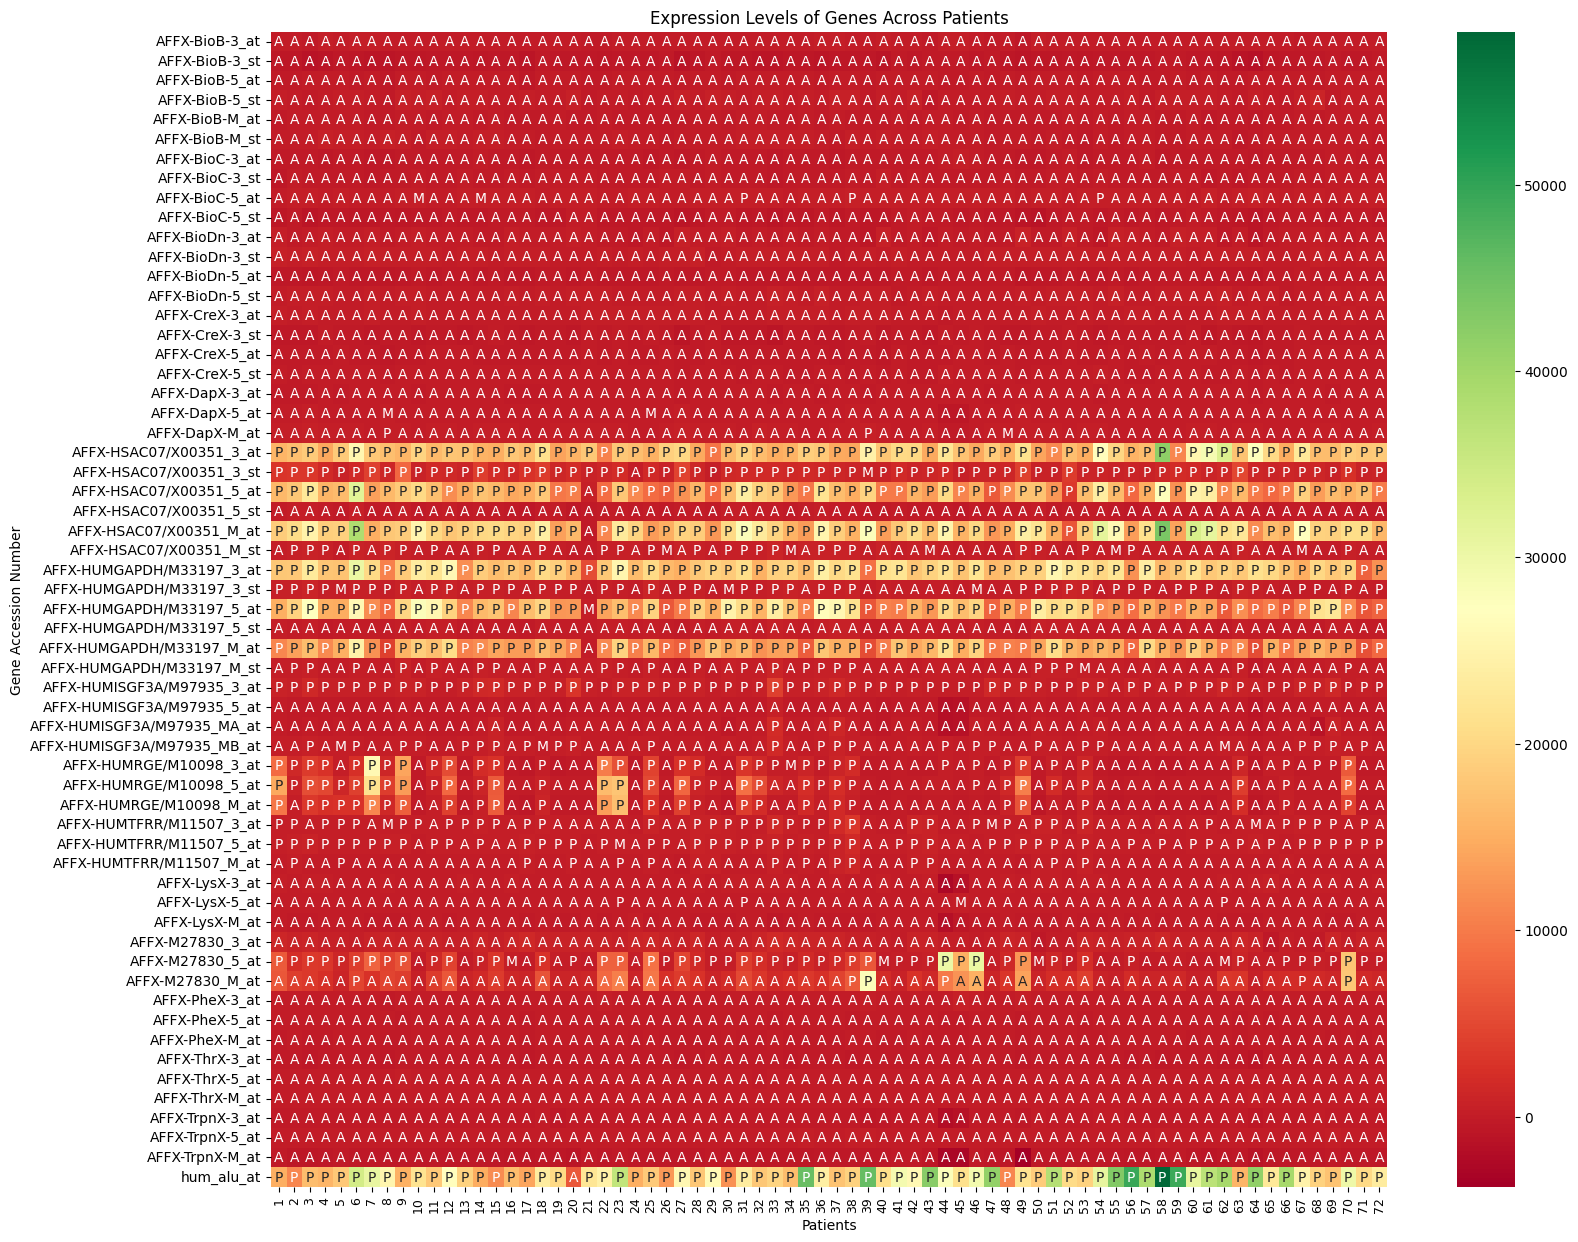

In [14]:
plt.figure(figsize=(18, 15))
sns.heatmap(pivoted_cntrls_expr, annot=pivot_cntrls_call, fmt='', cmap='RdYlGn')
plt.tick_params(axis='x', labelsize=9)
plt.title('Expression Levels of Genes Across Patients')
plt.xlabel('Patients')
plt.ylabel('Gene Accession Number')
plt.show()

Overall the quality seems consistent through all samples, with a mild exception for patient 21 that has several controls marked differently and with signficant different levels of expressions with respect to the other samples. However due to the limited amount of information associated with the data, it is not clear if this could be a technical issue or there are biological reasons behind this.

Now, to follow the rationale of the paper presented before, let's visualise better the distribution of call values. We can obtain, for each gene (probe) and for each call value the absolute count of samples (a scale that goes from 1 to 72).

In [15]:
gene_calls = melted_calls.groupby(['Gene Description', 'Gene Accession Number'])['call_val'].value_counts().reset_index(name='count')
gene_calls

,Gene Description,Gene Accession Number,call_val,count
0,(AF1q) mRNA,U16954_at,A,40
1,(AF1q) mRNA,U16954_at,P,32
2,(HepG2) glucose transporter gene mRNA,K03195_at,P,67
3,(HepG2) glucose transporter gene mRNA,K03195_at,M,4
4,(HepG2) glucose transporter gene mRNA,K03195_at,A,1
...,...,...,...,...
15102,mRNA; clone RES4-24A; exon 1; 2; 3; 4,AB000464_at,P,51
15103,mRNA; clone RES4-24A; exon 1; 2; 3; 4,AB000464_at,A,21
15104,mRNA; clone RES4-24C; exon 1; 2; 3,AB000466_at,A,72
15105,mRNA; clone RES4-25; partial cds,AB000467_at,A,71


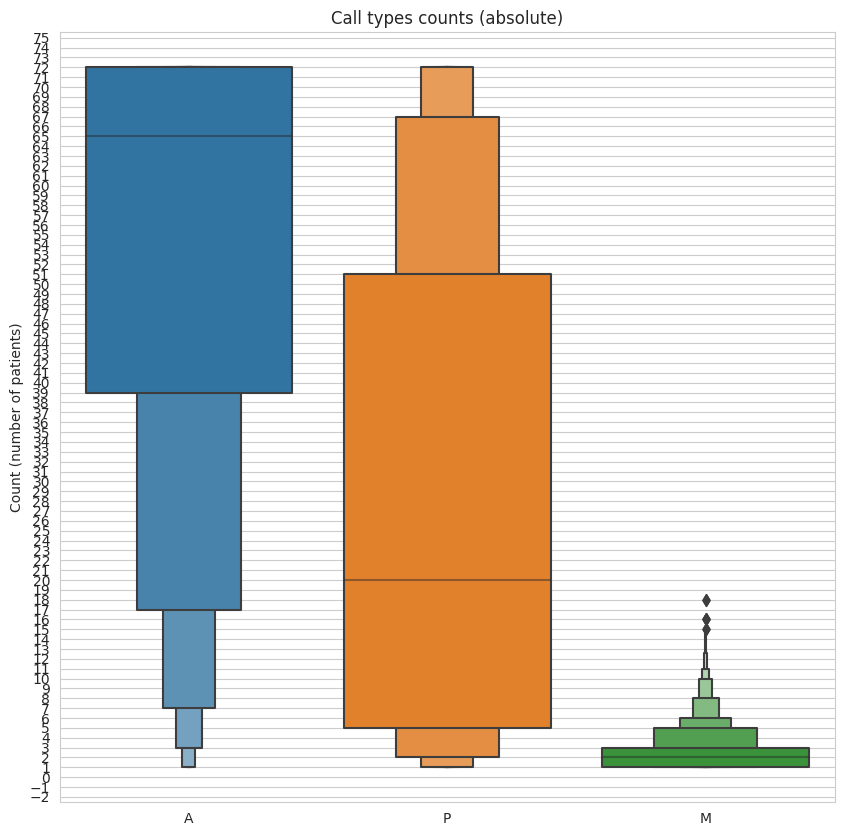

In [16]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 10), dpi=100)
sns.boxenplot(data=gene_calls, x="call_val", y="count")
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('Call types counts (absolute)')
plt.xlabel('')
plt.ylabel('Count (number of patients)')

plt.show()

We can immediately see that the Absent genes distribution is heavily skewed.

Finally let's check if the classes are balanced.

In [17]:
classes_counts = labels.groupby('cancer')['patient'].nunique()
classes_counts

cancer
ALL    47
AML    25
Name: patient, dtype: int64

The classes are imbalanced, since the ALL class contains almost double the samples than AML.

# Feature selection

To follow the approach of the paper we will split the dataset in the 2 types of cancer. For these 2 datasets then we will count the Present, Marginal and Absent calls score: this is calculated for each probe across all samples by summing 1 if the gene is present, 0.5 if the gene is marginal and 0 if the gene is absent. This can be then transformed into a percentage value on total.

In [18]:
dataset_all = gene_pt_calls[gene_pt_calls['cancer'] == 'ALL']
dataset_aml = gene_pt_calls[gene_pt_calls['cancer'] == 'AML']

In [19]:
patients_all = len(dataset_all['pt'].unique())
patients_aml = len(dataset_aml['pt'].unique())

In [20]:
call_counts_all = dataset_all.groupby(['Gene Description', 'Gene Accession Number'])['call_val'].value_counts().reset_index(name='count')
call_counts_aml = dataset_aml.groupby(['Gene Description', 'Gene Accession Number'])['call_val'].value_counts().reset_index(name='count')

In [21]:
# Check for each gene the sum is equal to the number of patients
call_counts_all.groupby(['Gene Description', 'Gene Accession Number']).sum('count').eq(patients_all).all()

count    True
dtype: bool

In [22]:
# Check for each gene the sum is equal to the number of patients
call_counts_aml.groupby(['Gene Description', 'Gene Accession Number']).sum('count').eq(patients_aml).all()

count    True
dtype: bool

In [23]:
# Add weights
call_counts_all['weight'] = np.where(call_counts_all['call_val'] == 'P', 1,
                                    np.where(call_counts_all['call_val'] == 'M', 0.5, 0))
call_counts_aml['weight'] = np.where(call_counts_aml['call_val'] == 'P', 1,
                                    np.where(call_counts_aml['call_val'] == 'M', 0.5, 0))

In [24]:
# Calculate scores
def score_calc(group, total):
    score = (group['count']*group['weight']).sum() / total
    return score


call_scores_all = call_counts_all.groupby('Gene Accession Number').apply(score_calc, total=patients_all)
call_scores_aml = call_counts_aml.groupby('Gene Accession Number').apply(score_calc, total=patients_aml)

In [25]:
call_scores = pd.concat({'ALL': call_scores_all, 'AML': call_scores_aml}, axis=1)

The paper reports that different thresholds are appropriate in different scenarios (sample size in the arrays set). Since we have limited information on how the actual arrays were performed and assuming our data could also be partial, it is advisable to start using the lowest recommended threshold, aka we will retain those genes that have a fraction present in at least one group >0% (we exclude genes that are absent in all samples).

In [26]:
retained = call_scores[(call_scores['ALL'] > 0) | call_scores['AML'] > 0]

In [27]:
gene_pt_calls_filt = gene_pt_calls[gene_pt_calls['Gene Accession Number'].isin(retained.index)]
# Let's exclude also the controls
gene_pt_calls_filt = gene_pt_calls_filt[~gene_pt_calls_filt['Gene Description'].isin(control_genes)]
gene_pt_calls_filt

,Gene Description,Gene Accession Number,pt,expr,call,call_val,patient,cancer
59,GB DEF = GABAa receptor alpha-3 subunit,A28102_at,1,151,1,A,1,ALL
60,Osteomodulin,AB000114_at,1,72,1,A,1,ALL
61,mRNA,AB000115_at,1,281,1,A,1,ALL
62,Semaphorin E,AB000220_at,1,36,1,A,1,ALL
63,MNK1,AB000409_at,1,-299,1,A,1,ALL
...,...,...,...,...,...,...,...,...
513283,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,X83863_at,62,551,62,A,62,AML
513284,HMG2 High-mobility group (nonhistone chromosom...,Z17240_at,62,194,62,A,62,AML
513285,RB1 Retinoblastoma 1 (including osteosarcoma),L49218_f_at,62,20,62,A,62,AML
513286,GB DEF = Glycophorin Sta (type A) exons 3 and ...,M71243_f_at,62,379,62,A,62,AML


In [28]:
t_gene_pt_calls_filt = pd.pivot(gene_pt_calls_filt.drop(['Gene Description', 'call', 'call_val', 'patient'], axis=1), columns="Gene Accession Number", values="expr", index="pt")
t_gene_pt_calls_filt

Gene Accession Number,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000381_s_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,...,Z83821_cds2_at,Z84497_s_at,Z84721_cds1_at,Z84721_cds2_at,Z86000_at,Z93784_at,Z94753_s_at,Z95624_at,Z97054_xpt2_at,Z97074_at
pt,,,,,,,,,,,,,,,,,,,,,
1,151,72,281,36,29,-299,57,186,1647,137,...,7,1162,302,8656,538,434,168,116,398,188
2,263,21,250,43,8,-103,169,219,2043,188,...,285,1803,294,13285,863,506,70,94,649,147
3,88,-27,358,42,11,142,359,237,1997,91,...,17,1547,37,15704,737,770,141,57,701,131
4,484,61,118,39,38,-11,274,245,2128,-82,...,10,1039,287,15691,882,348,102,179,533,448
5,118,16,197,39,50,237,311,186,1608,204,...,-9,644,-13,3390,386,484,123,66,448,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,206,19,101,-7,-16,101,347,188,1910,20,...,189,974,269,13576,670,920,149,110,1244,402
69,171,29,1421,15,48,125,382,308,1813,270,...,1256,1597,284,11148,503,665,69,55,1138,173
70,249,-3,215,49,38,27,37,129,1249,-12,...,344,911,191,21987,272,216,40,26,417,215


In [29]:
# Separate back
train_set = t_gene_pt_calls_filt[t_gene_pt_calls_filt.index.isin(patients_in_train)]
test_set = t_gene_pt_calls_filt[t_gene_pt_calls_filt.index.isin(patients_in_test)]

# Classification and interpretation using Random Forest

## Why Random Forest?

Gene expression datasets are typically high-dimensional, with the number of features (genes) far exceeding the number of samples. Random Forest is effective in managing high-dimensional data and avoids the curse of dimensionality better than many other algorithms. This is because each tree in the forest considers a random subset of features, preventing overfitting and ensuring diverse perspectives from different trees in the ensemble. Moreover, the algorithm mitigates the risk of overfitting by averaging the decisions of multiple trees and doesn't require feature scaling. Another key point is the interpretability of the model: by providing feature importance scores, we are able to detect which genes contribute more to the prediction.

Another alternative that follows also in the ensemble methods category is for sure XGBoost. In the context of this project I chose Random Forest mainly because it offers a good balance between performance and interpretability and it's simpler to tune compared to XGBoost.

## Code

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix, balanced_accuracy_score

In [31]:
SEED = 39582

In [32]:
X_train = train_set.reset_index().drop('pt', axis=1)
X_test = test_set.reset_index().drop('pt', axis=1)
y_train = labels[labels['patient'].isin(patients_in_train)]['cancer']
y_test = labels[labels['patient'].isin(patients_in_test)]['cancer']

In [33]:
# Encoding labels
le = LabelEncoder()
le.fit(y_train)
y_train_en = le.transform(y_train)
y_test_en = le.transform(y_test)

In [34]:
rf = RandomForestClassifier(random_state=SEED, n_jobs=-1)

In [35]:
param_grid = {
    'n_estimators': [40, 50, 55],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None],
    'class_weight': [None]
}

gs = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='f1', verbose=1)
gs.fit(X_train, y_train_en)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=39582),
             param_grid={'class_weight': [None],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': [None], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [40, 50, 55]},
             scoring='f1', verbose=1)

In [36]:
gs.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [37]:
y_pred = gs.predict(X_test)

In [38]:
bal_acc = balanced_accuracy_score(y_test_en, y_pred)
precision = precision_score(y_test_en, y_pred)
recall = recall_score(y_test_en, y_pred)
f1 = f1_score(y_test_en, y_pred)
roc_auc = roc_auc_score(y_test_en, y_pred)

print(f'Balanced accuracy: {bal_acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'ROC AUC: {roc_auc}')

Balanced accuracy: 0.8571428571428572
Precision: 1.0
Recall: 0.7142857142857143
F1-Score: 0.8333333333333333
ROC AUC: 0.8571428571428572


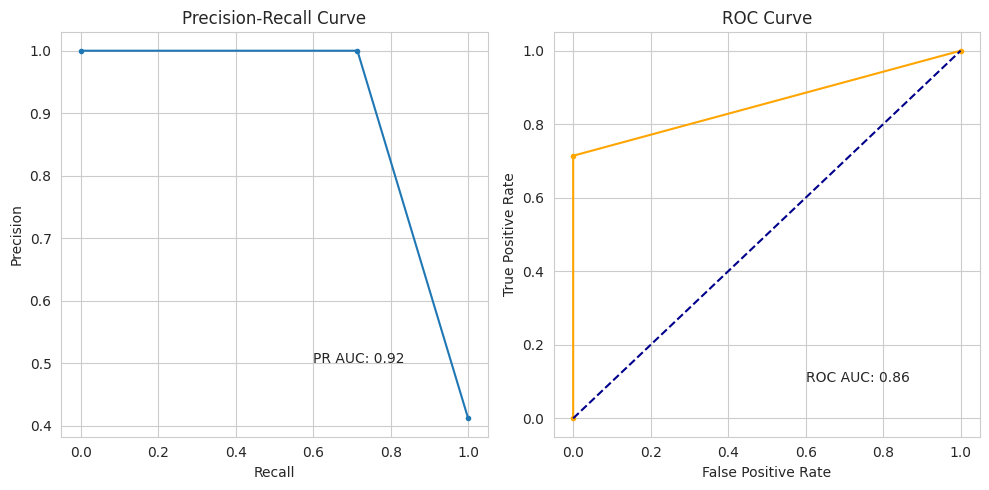

In [39]:
precision_points, recall_points, _ = precision_recall_curve(y_test_en, y_pred)
pr_auc = auc(recall_points, precision_points)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(recall_points, precision_points, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.text(0.6, 0.5, f'PR AUC: {pr_auc:.2f}')

fpr, tpr, _ = roc_curve(y_test_en, y_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='orange', marker='.')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.text(0.6, 0.1, f'ROC AUC: {roc_auc:.2f}')

plt.tight_layout()
plt.show()

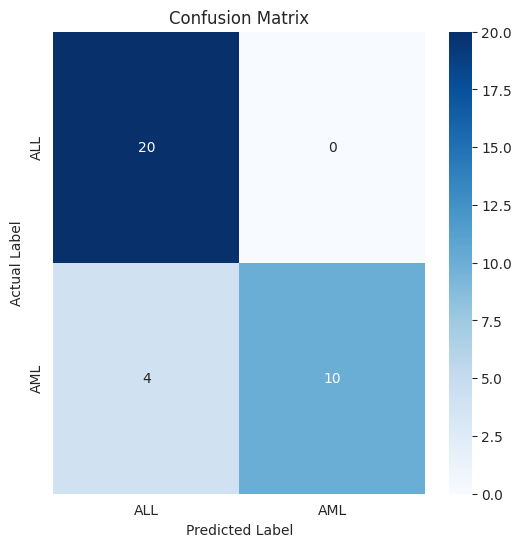

In [40]:
cm = confusion_matrix(y_test_en, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ALL', 'AML'], yticklabels=['ALL', 'AML'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Comments and conclusions

Rigorous hyperparameter tuning with GridSearchCV, focusing on the F1 score due to class imbalance, led to the identification of an optimal model configuration. The model achieved a balanced accuracy of 85.7%, showcasing effectiveness across both leukemia types. Notably, it demonstrated perfect precision of 100%, accurately identifying all AML cases without any false positives. However, with a recall of 71.4%, the model did miss some AML cases, indicating a potential area for improvement. The F1-Score of 83.3% and ROC AUC of 85.7% further affirm the model's robustness in handling imbalanced data.

# Feature importances

Analyzing the feature importances in the Random Forest classifier for leukemia classification using gene expression data can yield insightful observations. 

In [41]:
importances = gs.best_estimator_.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = pd.merge(feature_importances, training_data[['Gene Description', 'Gene Accession Number']], right_on='Gene Accession Number', left_on='feature')
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances.head(20)

,feature,importance,Gene Description,Gene Accession Number
4920,X95735_at,0.18,Zyxin,X95735_at
1858,M23197_at,0.06,CD33 CD33 antigen (differentiation antigen),M23197_at
1998,M31523_at,0.06,TCF3 Transcription factor 3 (E2A immunoglobuli...,M31523_at
1986,M31166_at,0.06,PTX3 Pentaxin-related gene; rapidly induced by...,M31166_at
3425,U50136_rna1_at,0.06,Leukotriene C4 synthase (LTC4S) gene,U50136_rna1_at
3370,U46751_at,0.06,Phosphotyrosine independent ligand p62 for the...,U46751_at
2515,M98399_s_at,0.04,CD36 CD36 antigen (collagen type I receptor; t...,M98399_s_at
2364,M83652_s_at,0.04,PFC Properdin P factor; complement,M83652_s_at
1829,M21551_rna1_at,0.04,Neuromedin B mRNA,M21551_rna1_at
2112,M55150_at,0.04,FAH Fumarylacetoacetate,M55150_at


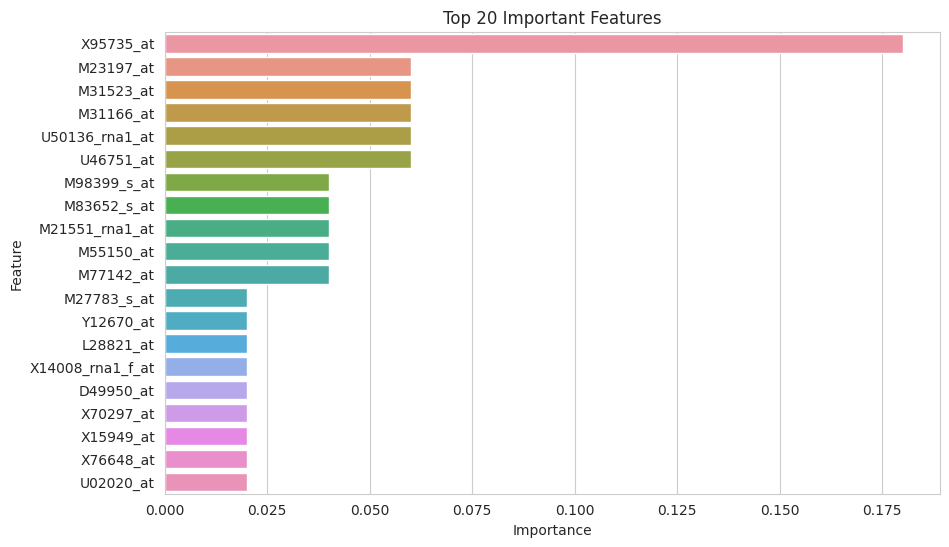

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title('Top 20 Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [43]:
import shap
explainer = shap.TreeExplainer(gs.best_estimator_)
shap_values = explainer.shap_values(X_train)

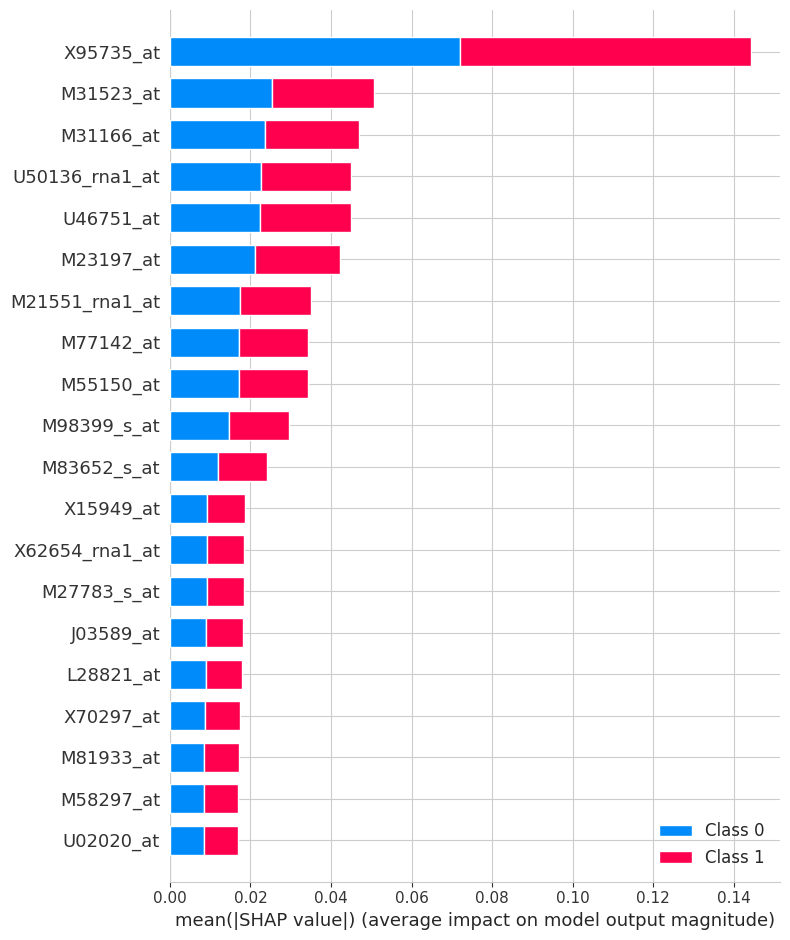

In [44]:
shap.summary_plot(shap_values, X_train)

The genes identified as most important offer potential targets for further biological research. Understanding their roles could provide deeper insights into the mechanisms of leukemia and potentially guide the development of targeted therapies.

From the plots we can observe that the gene that seem to contribute the most in the classification is X95735_at (Zyxin), moreover the balance between the 2 classes suggests that the model is not solely relying on the overexpression or underexpression of certain genes, but instead, it's sensitive to variations in both directions, which is reflective of the complex nature of gene expression's role in cancer.

Zyxin appears to be a gene of considerable interest in leukemia research, particularly in relation to ALL.

# References

McClintick JN, Edenberg HJ. Effects of filtering by Present call on analysis of microarray experiments. BMC Bioinformatics. 2006 Jan 31;7:49. doi: 10.1186/1471-2105-7-49. PMID: 16448562; PMCID: PMC1409797.